**Instituto Tecnológico de Aeronáutica – ITA**

**Inteligência Artificial para Robótica Móvel – CT-213**

**Professores:** 

Marcos Ricardo Omena de Albuquerque Maximo

André Oliveira Françani

# Laboratório 3 – Otimização com Métodos de Busca Local


Observação: para alterar este notebook, salve uma cópia no seu Drive em ``File > Save a copy in Drive``.

# 1. Introdução
 
Nesse laboratório, seu objetivo é implementar algoritmos de otimização baseados em busca local, a saber Descida do Gradiente, Hill Climbing e Simulated Annealing. Os métodos serão testados em um problema em que se usa regressão linear para obter parâmetros físicos relativos ao movimento de uma bola. No caso, trata-se apenas de um problema brinquedo, dado que esse problema especificamente tem solução analítica, logo o Método dos Mínimos Quadrados (MMQ) o resolve mais facilmente.

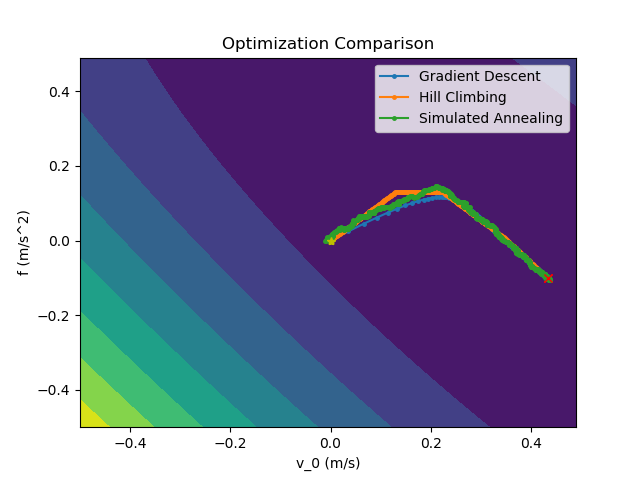

**Figura 1**: comparação de trajetórias de otimização usando Gradient Descent, Hill Climbing e Simulated Annealing.

# 2. Descrição do Problema

O problema ser resolvido é a otimização de funções matemáticas (em que é possível obter amostras da função e de sua derivada) usando os métodos descritos, assim sua implementação não deve ser específica para o caso de teste. As descrições dos algoritmos que serão implementados podem ser vistas nos slides do curso.

No caso de teste, o problema específico a ser resolvido é a determinação do coeficiente de desaceleração de uma bola em movimento num campo de futebol de robôs. A bola em movimento perde energia devido a um fenômeno conhecido como *rolling friction*. Conforme explicado em aula, pode-se determinar o coeficiente de desaceleração através do seguinte algoritmo:

1. Usar câmera e visão computacional para obter posições (x,y) da bola em cada instante.
2. Calcular velocidades em x e y usando diferenças finitas centradas (exceto no primeiro e último elementos, em que deve-se usar derivadas *forward* e *backward*, respectivamente):

    $$v_x [k]=(x[k+1]-x[k-1])/(t[k+1]-t[k-1])$$
    $$v_y [k]=(y[k+1]-y[k-1])/(t[k+1]-t[k-1])$$

3. Calcular $v[k]= \sqrt{v_x^2[k] + v_y^2[k]}$.
4. Obter $v_0$ e $f$ através de uma otimização com função de custo:

    $$J([v_0,f])= \sum_{k=1}^n (v_0 + ft[k]-v[k])^2$$
    
Desse modo, tem-se os seguintes parâmetros a serem otimizados: 

$\theta_0 = v_0$ e $\theta_1 = f \Rightarrow \theta =[v_0  \: f]^T$

# 3. Código Base

Juntamente com o código base, foi entregue o arquivo data.txt, que contém dados reais do movimento de uma bola no campo de futebol de robôs do Very Small Size (VSS). Esses dados foram obtidos pelo aluno Thiago Filipe de Medeiros da COMP-19 durante uma competição. Para isso, usou-se o *setup* do VSS, incluindo os algoritmos de visão computacional da ITAndroids.

O código base entregue já carrega esses dados automaticamente e os pré-processa de acordo com o procedimento explicado na seção anterior. Além disso, resolve a otimização com uso do MMQ a fim de fornecer valores esperados para $v_0$ e $f$. O código base também já executa os algoritmos que você vai implementar e apresenta gráficos para que você possa verificar sua implementação.

# 4. Tarefas

Você deve implementar os algoritmos Descida do Gradiente, *Hill Climbing* e *Simulated Annealing*. Para isso, implemente as seguintes funções:
	
* gradient_descent()
* hill_climbing()
* simulated_annealing()
    
As implementações desses algoritmos de otimização devem ser as mais genéricas possível e não usar informações específicas do problema de fit da dinâmica da bola. Perceba que as condições de parada de todos os algoritmos envolvem um limiar para o custo (i.e. o algoritmo pára quando $J(\theta)<\epsilon$) e um número máximo de iterações.


Comece rodando a célula abaixo para fazer o download dos dados.

In [ ]:
import zipfile
import os

# Download data (MUST RUN)
!gdown --id 1BvhSp6zW_OOxIpwg53PB0I99e9xt4sPM

with zipfile.ZipFile("lab3_ct213_2022.zip","r") as zip_ref:
  zip_ref.extractall() # extracts in current directory

# make results folder to save images
if not os.path.exists('results'):
  os.makedirs('results')
  
os.remove("lab3_ct213_2022.zip")

A célula abaixo contém funções auxiliares já implementadas para os alunos, sendo elas:
- cost_function(): função custo a ser otimizada;
- plot_optimization(): plota o histórico da otimização.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def cost_function(theta):
    """
    Samples the linear regression cost function.

    :param theta: parameter point.
    :type theta: numpy.array.
    :return: cost value at theta.
    :rtype: float.
    """
    return sum((theta[0] + theta[1] * t - v) ** 2) / (2.0 * m)

def plot_optimization(history):
    """
    Plots the optimization history.

    :param history: points visited by the optimization algorithm.
    :type history: list of numpy.array.
    """
    t0 = np.arange(-0.5, 0.5, 0.01)
    t1 = np.arange(-0.5, 0.5, 0.01)
    z = np.zeros((len(t0), len(t1)))
    for i in range(len(t0)):
        for j in range(len(t1)):
            z[i, j] = cost_function(np.array([t0[i], t1[j]]))
    plt.contourf(t0, t1, z.transpose())
    hx = []
    hy = []
    for h in history:
        hx.append(h[0])
        hy.append(h[1])
    handle, = plt.plot(hx, hy, '.-', markersize=5)
    plt.xlabel('v_0 (m/s)')
    plt.ylabel('f (m/s^2)')
    plt.plot(hx[0], hy[0], '*y')
    plt.plot(hx[-1], hy[-1], 'xr')
    return handle

## 4.1 Descida do Gradiente

A função auxiliar ``gradient_function()`` já foi fornecida como exemplo, e portanto não precisa ser implementada. Você precisa apenas implementar a função ``gradient_descent()``.

In [ ]:
def gradient_function(theta):
    """
    Samples the gradient of the linear regression cost function.

    :param theta: parameter point.
    :type theta: numpy.array.
    :return: gradient at theta.
    :rtype: float.
    """
    return np.array([(1 / m) * sum(theta[0] + theta[1] * t - v),
                    (1 / m) * sum((theta[0] + theta[1] * t - v) * t)])

$\color{red}{\textbf{Implemente aqui a função gradient_descent():}}$

In [ ]:
def gradient_descent(cost_function, gradient_function, theta0, alpha, epsilon, max_iterations):
    """
    Executes the Gradient Descent (GD) algorithm to minimize (optimize) a cost function.

    :param cost_function: function to be minimized.
    :type cost_function: function.
    :param gradient_function: gradient of the cost function.
    :type gradient_function: function.
    :param theta0: initial guess.
    :type theta0: numpy.array.
    :param alpha: learning rate.
    :type alpha: float.
    :param epsilon: used to stop the optimization if the current cost is less than epsilon.
    :type epsilon: float.
    :param max_iterations: maximum number of iterations.
    :type max_iterations: int.
    :return theta: local minimum.
    :rtype theta: numpy.array.
    :return history: history of points visited by the algorithm.
    :rtype history: list of numpy.array.
    """
    theta = theta0
    history = [theta0]
    # Todo: Implement Gradient Descent
    return theta, history
    

### Teste da Implementação Descida do Gradiente

In [ ]:
import random


def fit_gradient_descent():
    """
    Uses Gradient Descent (GD) to fit the ball parameters.

    :return theta: array containing the initial speed and the acceleration factor due to rolling friction.
    :rtype theta: numpy.array.
    :return history: history of points visited by the algorithm.
    :rtype history: list of numpy.array.
    """
    theta, history = gradient_descent(cost_function, gradient_function, np.array([0.0, 0.0]), 0.1, 1.0e-10, 1000)
    return theta, history


fig_format = 'png'
# fig_format = 'svg'
# fig_format = 'eps'
# Recommended figure formats: .eps for Latex/Linux, .svg for MS Office, and .png for easy visualization in Windows.
# The quality of .eps and .svg is far superior since these are vector graphics formats.

# Setting random seed for reproducibility
random.seed(100)

# Loading and pre-processing data
data = np.genfromtxt('data.txt')
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]
t -= t[0]
m = len(t)
vx = np.zeros(m)
vy = np.zeros(m)
vx[0] = (x[1] - x[0]) / (t[1] - t[0])
vy[0] = (y[1] - y[0]) / (t[1] - t[0])
for k in range(1, m - 1):
    vx[k] = (x[k + 1] - x[k - 1]) / (t[k + 1] - t[k - 1])
    vy[k] = (y[k + 1] - y[k - 1]) / (t[k + 1] - t[k - 1])
vx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
vy[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])
v = np.sqrt(vx ** 2 + vy ** 2)

# Solving the problem using Gradient Descent algorithm
theta_gd, history_gd = fit_gradient_descent()
print('Gradient Descent solution: ', theta_gd)
plt.figure()
plot_optimization(history_gd)
plt.title('Gradient Descent')
plt.savefig(os.path.join('results', 'gradient_descent.%s' % fig_format), format=fig_format)

## 4.2 Hill Climbing

Para os vizinhos de um ponto no *Hill Climbing*, use uma estratégia 8-conectada: pegue 8 vizinhos igualmente espaçados em ângulo e a uma distância Δ do ponto atual, conforme mostra a Figura 2. 


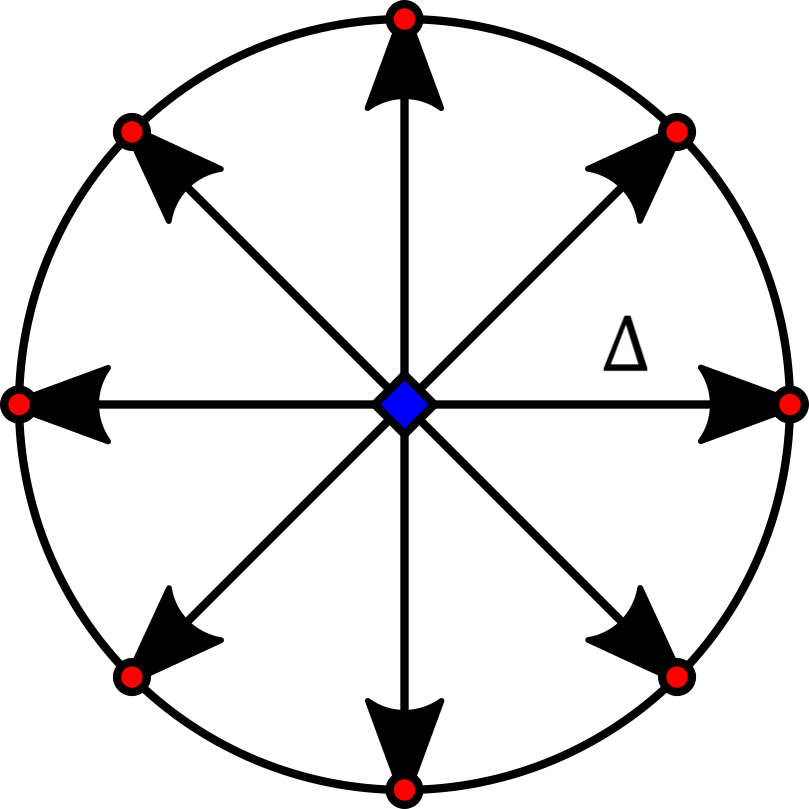

**Figura 2**: vizinhos em estratégia 8-conectada usada no Hill Climbing.

Neste método de otimização, a função auxiliar ``neighbors()`` deve ser implementada pelos alunos. A função ``cost_function()`` já foi implementada anteriormente. 

$\color{red}{\textbf{Implemente aqui a função auxiliar neighbors()}}$

In [ ]:
from math import pi, cos, sin


# Hyperparameters used for computing the neighbors
delta = 2.0e-3
num_neighbors = 8
    
def neighbors(theta):
    """
    Returns 8-connected neighbors of point theta.
    The neighbors are sampled around a circle of radius "delta".
    Equally spaced (in terms of angle) "num_neighbors" neighbors are sampled.

    :param theta: current point.
    :type theta: numpy.array.
    :return: neighbors of theta.
    :rtype: list of numpy.array.
    """
    neighbors_list = []
    # Todo: Implement
    return neighbors_list
    

$\color{red}{\textbf{Implemente aqui a função hill_climbing():}}$

In [ ]:
from math import inf


def hill_climbing(cost_function, neighbors, theta0, epsilon, max_iterations):
    """
    Executes the Hill Climbing (HC) algorithm to minimize (optimize) a cost function.

    :param cost_function: function to be minimized.
    :type cost_function: function.
    :param neighbors: function which returns the neighbors of a given point.
    :type neighbors: list of numpy.array.
    :param theta0: initial guess.
    :type theta0: numpy.array.
    :param epsilon: used to stop the optimization if the current cost is less than epsilon.
    :type epsilon: float.
    :param max_iterations: maximum number of iterations.
    :type max_iterations: int.
    :return theta: local minimum.
    :rtype theta: numpy.array.
    :return history: history of points visited by the algorithm.
    :rtype history: list of numpy.array.
    """
    theta = theta0
    history = [theta0]
    # Todo: Implement Hill Climbing
    return theta, history


### Teste da Implementação do Hill Climbing

In [ ]:
import random


def fit_hill_climbing():
    """
    Uses Hill Climbing (HC) to fit the ball parameters.

    :return theta: array containing the initial speed and the acceleration factor due to rolling friction.
    :rtype theta: numpy.array.
    :return history: history of points visited by the algorithm.
    :rtype history: list of numpy.array.
    """
    theta, history = hill_climbing(cost_function, neighbors, np.array([0.0, 0.0]), 1.0e-10, 1000)
    return theta, history


fig_format = 'png'
# fig_format = 'svg'
# fig_format = 'eps'
# Recommended figure formats: .eps for Latex/Linux, .svg for MS Office, and .png for easy visualization in Windows.
# The quality of .eps and .svg is far superior since these are vector graphics formats.

# Setting random seed for reproducibility
random.seed(100)

# Loading and pre-processing data
data = np.genfromtxt('data.txt')
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]
t -= t[0]
m = len(t)
vx = np.zeros(m)
vy = np.zeros(m)
vx[0] = (x[1] - x[0]) / (t[1] - t[0])
vy[0] = (y[1] - y[0]) / (t[1] - t[0])
for k in range(1, m - 1):
    vx[k] = (x[k + 1] - x[k - 1]) / (t[k + 1] - t[k - 1])
    vy[k] = (y[k + 1] - y[k - 1]) / (t[k + 1] - t[k - 1])
vx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
vy[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])
v = np.sqrt(vx ** 2 + vy ** 2)

# Solving the problem using Hill Climbing algorithm
theta_hc, history_hc = fit_hill_climbing()
print('Hill Climbing solution: ', theta_hc)
plt.figure()
plot_optimization(history_hc)
plt.title('Hill Climbing')
plt.savefig(os.path.join('results', 'hill_climbing.%s' % fig_format), format=fig_format)

## 4.3 Simulated Annealing

Para o vizinho aleatório do *Simulated Annealing*, considere um ponto a uma distância $\Delta$ do ponto atual e com ângulo amostrado aleatoriamente com distribuição uniforme no intervalo $(-\pi, \pi)$. Para o escalonamento de temperatura, use a seguinte equação:

$$T= \frac{T_0}{1+\beta i^2}$$ 
em que $T_0$ e $\beta$ são hiperparâmetros e $i$ é a iteração atual (começando em 0). Observe que valores adequados de $\Delta$, $T_0$ e $\beta$ já foram fornecidos junto com a implementação das funções auxiliares.

As funções auxiliares para este método devem ser implementadas, sendo elas:
* random_neighbor()
* schedule()


$\color{red}{\textbf{Implemente aqui as funções auxiliares random_neighbor() e schedule():}}$


In [ ]:
from math import pi, cos, sin


# Hyperparameters used for computing the random neighbor
delta = 2.0e-3
# Hyperparameters used for computing the temperature scheduling
temperature0 = 1.0
beta = 1.0

def random_neighbor(theta):
    """
    Returns a random neighbor of theta.
    The random neighbor is sampled around a circle of radius <delta>.
    The probability distribution of the angle is uniform(-pi, pi).

    :param theta: current point.
    :type theta: numpy.array.
    :return: random neighbor.
    :rtype: numpy.array.
    """
    # Todo: Implement
    pass  # Remove pass after implementing

def schedule(i):
    """
    Defines the temperature schedule of the simulated annealing.

    :param i: current iteration.
    :type i: int.
    :return: current temperature.
    :rtype: float.
    """
    # Todo: Implement
    pass  # Remove pass after implementing

$\color{red}{\textbf{Implemente aqui a função simulated_annealing():}}$

In [ ]:
from math import exp
import random


def simulated_annealing(cost_function, random_neighbor, schedule, theta0, epsilon, max_iterations):
    """
    Executes the Simulated Annealing (SA) algorithm to minimize (optimize) a cost function.

    :param cost_function: function to be minimized.
    :type cost_function: function.
    :param random_neighbor: function which returns a random neighbor of a given point.
    :type random_neighbor: numpy.array.
    :param schedule: function which computes the temperature schedule.
    :type schedule: function.
    :param theta0: initial guess.
    :type theta0: numpy.array.
    :param epsilon: used to stop the optimization if the current cost is less than epsilon.
    :type epsilon: float.
    :param max_iterations: maximum number of iterations.
    :type max_iterations: int.
    :return theta: local minimum.
    :rtype theta: np.array.
    :return history: history of points visited by the algorithm.
    :rtype history: list of np.array.
    """
    theta = theta0
    history = [theta0]
    # Todo: Implement Simulated Annealing
    return theta, history


### Teste da Implementação do Simulated Annealing


In [ ]:
import random

def fit_simulated_annealing():
    """
    Uses Simulated Annealing (SA) to fit the ball parameters.

    :return theta: array containing the initial speed and the acceleration factor due to rolling friction.
    :rtype theta: numpy.array.
    :return history: history of points visited by the algorithm.
    :rtype history: list of numpy.array.
    """
    theta, history = simulated_annealing(cost_function, random_neighbor, schedule, np.array([0.0, 0.0]), 1.0e-10, 5000)
    return theta, history


fig_format = 'png'
# fig_format = 'svg'
# fig_format = 'eps'
# Recommended figure formats: .eps for Latex/Linux, .svg for MS Office, and .png for easy visualization in Windows.
# The quality of .eps and .svg is far superior since these are vector graphics formats.

# Setting random seed for reproducibility
random.seed(100)

# Loading and pre-processing data
data = np.genfromtxt('data.txt')
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]
t -= t[0]
m = len(t)
vx = np.zeros(m)
vy = np.zeros(m)
vx[0] = (x[1] - x[0]) / (t[1] - t[0])
vy[0] = (y[1] - y[0]) / (t[1] - t[0])
for k in range(1, m - 1):
    vx[k] = (x[k + 1] - x[k - 1]) / (t[k + 1] - t[k - 1])
    vy[k] = (y[k + 1] - y[k - 1]) / (t[k + 1] - t[k - 1])
vx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
vy[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])
v = np.sqrt(vx ** 2 + vy ** 2)

# Solving the problem using Simulated Annealing algorithm
theta_sa, history_sa = fit_simulated_annealing()
print('Simulated Annealing solution: ', theta_sa)
plt.figure()
plot_optimization(history_sa)
plt.title('Simulated Annealing')
plt.savefig(os.path.join('results', 'simulated_annealing.%s' % fig_format), format=fig_format)

## 4.4 Comparação dos Métodos

In [ ]:
import random
from math import pi, cos, sin
from least_squares import least_squares

def fit_least_squares():
    """
    Uses the Least Squares Method to fit the ball parameters.

    :return: array containing the initial speed and the acceleration factor due to rolling friction.
    :rtype: numpy.array.
    """
    return least_squares([lambda x: 1.0, lambda x: x], t, v)


fig_format = 'png'
# fig_format = 'svg'
# fig_format = 'eps'
# Recommended figure formats: .eps for Latex/Linux, .svg for MS Office, and .png for easy visualization in Windows.
# The quality of .eps and .svg is far superior since these are vector graphics formats.

# Setting random seed for reproducibility
random.seed(100)

# Loading and pre-processing data
data = np.genfromtxt('data.txt')
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]
t -= t[0]
m = len(t)
vx = np.zeros(m)
vy = np.zeros(m)
vx[0] = (x[1] - x[0]) / (t[1] - t[0])
vy[0] = (y[1] - y[0]) / (t[1] - t[0])
for k in range(1, m - 1):
    vx[k] = (x[k + 1] - x[k - 1]) / (t[k + 1] - t[k - 1])
    vy[k] = (y[k + 1] - y[k - 1]) / (t[k + 1] - t[k - 1])
vx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
vy[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])
v = np.sqrt(vx ** 2 + vy ** 2)

# Solving the problem using Least Squares in order to obtain ground truth
theta_ls = fit_least_squares()

# Solving the problem using each algorithm and plotting the optimization history of each algorithm
theta_gd, history_gd = fit_gradient_descent()
theta_hc, history_hc = fit_hill_climbing()
theta_sa, history_sa = fit_simulated_annealing()

# Tracing the optimization histories in a single plot for comparison
plt.figure()
handle_gd = plot_optimization(history_gd)
handle_hc = plot_optimization(history_hc)
handle_sa = plot_optimization(history_sa)
plt.legend([handle_gd, handle_hc, handle_sa], ['Gradient Descent', 'Hill Climbing', 'Simulated Annealing'])
plt.title('Optimization Comparison')
plt.savefig(os.path.join('results', 'optimization_comparison.%s' % fig_format), format=fig_format)

# Plotting the curve fit
plt.figure()
plt.plot(t, v, '*k')
v_ls = theta_ls[0] + theta_ls[1] * t
v_gd = theta_gd[0] + theta_gd[1] * t
v_hc = theta_hc[0] + theta_hc[1] * t
v_sa = theta_sa[0] + theta_sa[1] * t
plt.plot(t, v_ls, 'tab:red')
plt.plot(t, v_gd, 'tab:blue')
plt.plot(t, v_hc, 'tab:orange')
plt.plot(t, v_sa, 'tab:green')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend(['Data Points', 'Least Squares', 'Gradient Descent', 'Hill Climbing', 'Simulated Annealing'])
plt.title('Curve Fit')
plt.savefig(os.path.join('results', 'fit_comparison.%s' % fig_format), format=fig_format)
plt.show()

In [ ]:
import pandas as pd

# create comparison table
tb = pd.DataFrame(data = np.vstack((theta_ls, theta_gd, theta_hc, theta_sa)),
                  columns = ["v0", "f"],
                  index = ["MMQ", "Descida do Gradiente", "Hill Climbing", "Simulated Annealing"],
                 )
print("Parâmetros da regressão linear obtidos pelos métodos de otimização")
display(tb)

# 5. Entrega

A entrega consiste do notebook no formato .ipynb e de um relatório, submetida através do Google Classroom. Modificações nos arquivos do código base são permitidas, desde que o nome e a interface dos scripts “main” não sejam alterados. A princípio, não há limitação de número de páginas para o relatório, mas pede-se que seja sucinto. O relatório deve conter:

- Breve descrição em alto nível da sua implementação.
- Figuras que comprovem o funcionamento do seu código.

Por limitações do Google Classroom (e por motivo de facilitar a automatização da correção), entregue seu laboratório com todos os arquivos num único arquivo **.zip** (**não** utilize outras tecnologias de compactação de arquivos) com o seguinte padrão de nome: **“<login_email_google_education>_labX.zip”**. Por exemplo, no meu caso, meu login Google Education é **marcos.maximo**, logo eu entregaria o lab 3 como **“marcos.maximo_lab3.zip”**. **Não** crie subpastas para os arquivos da sua entrega, **deixe todos os arquivos na “raiz” do .zip**. Os relatórios devem ser entregues em formato **.pdf**.


# 6. Dicas

-	Para criar um vetor com dois elementos em NumPy, faça:
``` python
vector = np.array([1, 2])
```
-	Para amostrar um valor aleatoriamente com distribuição uniforme no intervalo (a, b), use:
```python
X = random.uniform(a, b)
```

- Para fazer o download do notebook no Colab, vá em ``File > Download >  Download .ipynb``

- Para fazer o download das figuras e usá-las no relatório, use os seguintes comandos:
```python
from google.colab import files
import os
os.system('zip -r lab3_results.zip results')
files.download("lab3_results.zip")
```